In [1]:
%matplotlib inline

## Covariance
- A covariance matrix can be imagined as a model of a population's scatter plot shape. These tools assume observations are IID (independent & identically distributed).
- Empirical, Shrunk, Sparse Inverse, Robust

## [Empirical Covariance](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EmpiricalCovariance.html#sklearn.covariance.EmpiricalCovariance), aka Max Likelihood Estimator (MLE)
- A dataset's CV matrix can be modeled via MLE if the #observations is high enough.
- Results depend on whether the data is centered (```assume_centered```). If False, the test set is supposed to have the same mean vector as the training set.

## [Shrunk Covariance](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.ShrunkCovariance.html#sklearn.covariance.ShrunkCovariance)
- MLE is not a good model of a CV matrix's eigenvalues - so the precision matrix you get from its inversion is not accurate. Shrinkage helps to avoid this problem.
- Scikit can apply a shrink transform with a user-defined ```shrinkage``` coefficient. Shrinkage is defined as reducing the ratio between the smallest & largest eigenvalues of an empirical CV matrix. It's done by shifting every eigenvalue by a given offset - this is equivalent to finding an L2-penalized MLE of the CV matrix. It boils down to this: $\Sigma_{\rm
shrunk} = (1-\alpha)\hat{\Sigma} + \alpha\frac{{\rm
Tr}\hat{\Sigma}}{p}\rm Id$.
- Choosing the shrinkage factor amounts to finding a bias/variance tradeoff.

## [Optimal Shrinkage (Ledoit-Wolf)](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.LedoitWolf.html#sklearn.covariance.LedoitWolf)
- Finds alpha that minimizes the Mean Squared Error (MSE) between the estimated and real CV matrix.

## [Optimal Shrinkage (Oracle Approximating Shrinkage, OAS)](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.OAS.html#sklearn.covariance.OAS)
- Assumes data has a Gaussian distribution.
- Yields a smaller MSE than the LW estimator.

## Comparison

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, log_likelihood, empirical_covariance
from sklearn.model_selection import GridSearchCV

In [3]:
# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test  = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train         = np.dot(base_X_train, coloring_matrix)
X_test          = np.dot(base_X_test,  coloring_matrix)

In [4]:
# Compute the likelihood on test data

# spanning a range of possible shrinkage coefficient values
shrinkages       = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# ground-truth model (we would not have in real settings)
real_cov    = np.dot(coloring_matrix.T, 
                     coloring_matrix)
emp_cov     = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, 
                              linalg.inv(real_cov))

In [5]:
# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{'shrinkage': shrinkages}]
cv               = GridSearchCV(ShrunkCovariance(), 
                                tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf
lw = LedoitWolf()
oa = OAS()

loglik_lw = lw.fit(X_train).score(X_test)
loglik_oa = oa.fit(X_train).score(X_test)

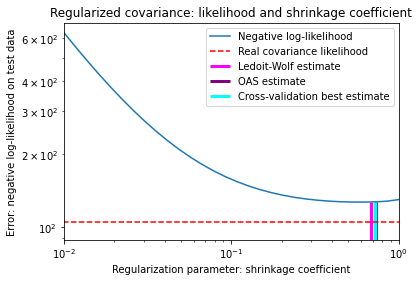

In [6]:
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')

# range shrinkage curve
plt.loglog(shrinkages, 
           negative_logliks, 
           label="Negative log-likelihood")

plt.plot(plt.xlim(), 
         2 * [loglik_real], '--r',
         label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin    = lik_min -  6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax    = lik_max + 10. * np.log(lik_max        - lik_min)
xmin    = shrinkages[0]
xmax    = shrinkages[-1]

# LW likelihood
plt.vlines(lw.shrinkage_, 
           ymin, 
           -loglik_lw, 
           color='magenta', linewidth=3, label='Ledoit-Wolf estimate')
# OAS likelihood
plt.vlines(oa.shrinkage_, 
           ymin, 
           -loglik_oa, 
           color='purple', linewidth=3, label='OAS estimate')
# best CV estimator likelihood
plt.vlines(cv.best_estimator_.shrinkage, 
           ymin,
           -cv.best_estimator_.score(X_test), 
           color='cyan',
           linewidth=3, label='Cross-validation best estimate')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()
plt.show()

## Comparison

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky
from sklearn.covariance import LedoitWolf, OAS

np.random.seed(0)

In [8]:
# simulation covariance matrix (AR(1) process)
n_features      = 100
r               = 0.1
real_cov        = toeplitz(r ** np.arange(n_features))
coloring_matrix = cholesky(real_cov)
n_samples_range = np.arange(6, 31, 1)
repeat          = 100
lw_mse          = np.zeros((n_samples_range.size, repeat))
oa_mse          = np.zeros((n_samples_range.size, repeat))
lw_shrinkage    = np.zeros((n_samples_range.size, repeat))
oa_shrinkage    = np.zeros((n_samples_range.size, repeat))

for i, n_samples in enumerate(n_samples_range):
    for j in range(repeat):
        X = np.dot(
            np.random.normal(size=(n_samples, 
                                   n_features)), 
            coloring_matrix.T)

        lw = LedoitWolf(store_precision=False, 
                        assume_centered=True)
        lw.fit(X)
        
        lw_mse[i, j] = lw.error_norm(real_cov, 
                                     scaling=False)
        lw_shrinkage[i, j] = lw.shrinkage_

        oa = OAS(store_precision=False, 
                 assume_centered=True)
        oa.fit(X)
        oa_mse[i, j] = oa.error_norm(real_cov, 
                                     scaling=False)
        oa_shrinkage[i, j] = oa.shrinkage_

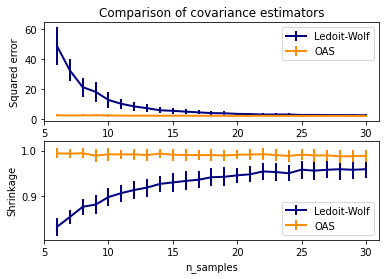

In [9]:
# plot MSE
plt.subplot(2, 1, 1)
plt.errorbar(n_samples_range, lw_mse.mean(1), yerr=lw_mse.std(1),
             label='Ledoit-Wolf', color='navy', lw=2)
plt.errorbar(n_samples_range, oa_mse.mean(1), yerr=oa_mse.std(1),
             label='OAS', color='darkorange', lw=2)
plt.ylabel("Squared error")
plt.legend(loc="upper right")
plt.title("Comparison of covariance estimators")
plt.xlim(5, 31)

# plot shrinkage coefficient
plt.subplot(2, 1, 2)
plt.errorbar(n_samples_range, lw_shrinkage.mean(1), yerr=lw_shrinkage.std(1),
             label='Ledoit-Wolf', color='navy', lw=2)
plt.errorbar(n_samples_range, oa_shrinkage.mean(1), yerr=oa_shrinkage.std(1),
             label='OAS', color='darkorange', lw=2)
plt.xlabel("n_samples")
plt.ylabel("Shrinkage")
plt.legend(loc="lower right")
plt.ylim(plt.ylim()[0], 1. + (plt.ylim()[1] - plt.ylim()[0]) / 10.)
plt.xlim(5, 31)

plt.show()

## [Sparse inverse covariance (aka Graphical Lasso)](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphicalLasso.html#sklearn.covariance.GraphicalLasso)
- The inverse of a CV matrix (aka "precision matrix") is proportional to a partial correlation matrix. It provides a partial independence relationship. (In other words: if two features in conditionally independent on all others, the corresponding value in the precision matrix will be zero.)
- Sparse inverse CV  estimators tend to work better than shrunk CV estimators when #samples ~ #features (or smaller). However they can be unstable in opposite situations.
- **GraphicalLasso** uses an L1 penalty to enforce sparsity on a precision matrix - higher alphas = more sparsity. **GraphicalLassoCV** uses cross-validation to automatically set alpha.

In [10]:
import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
import matplotlib.pyplot as plt

In [11]:
n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, 
                              alpha         = .98,
                              smallest_coef = .4,
                              largest_coef  = .7,
                              random_state  = prng)
cov   = linalg.inv(prec)
d     = np.sqrt(np.diag(cov))
cov  /= d
cov  /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X     = prng.multivariate_normal(np.zeros(n_features), 
                                 cov, 
                                 size=n_samples)
X    -= X.mean(axis=0)
X    /= X.std(axis=0)

In [12]:
# Estimate the covariance
emp_cov    = np.dot(X.T, X) / n_samples
model      = GraphicalLassoCV()
model.fit(X)
cov_       = model.covariance_
prec_      = model.precision_
lw_cov_, _ = ledoit_wolf(X)
lw_prec_   = linalg.inv(lw_cov_)

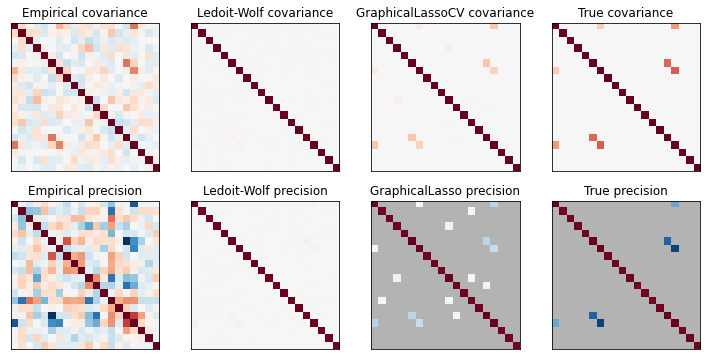

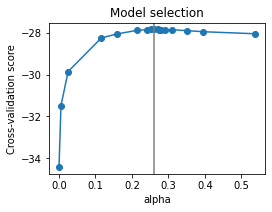

In [13]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_cov), ('Ledoit-Wolf', lw_cov_),
        ('GraphicalLassoCV', cov_), ('True', cov)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)


# plot the precisions
precs = [('Empirical', linalg.inv(emp_cov)), ('Ledoit-Wolf', lw_prec_),
         ('GraphicalLasso', prec_), ('True', prec)]
vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')

# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_alphas_, np.mean(model.grid_scores_, axis=1), 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()

## [Robust CV Estimation with FastMCD](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html#sklearn.covariance.MinCovDet)
- Scikit uses **Minimum Covariance Determinant** to handle data errors, outliers, etc.
- MCD finds a given proportion _h_ of "good" observations that are not outliers, and return their empirical CV matrix. This matrix is then rescaled to compensate for the selection process.
- With the MCD estimator one can weight observations using their **Mahalanobis distance**, leading to a re-weighted CV matrix.

## Comparison: Robust vs Empirical CV Estimates

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [15]:
# example settings
n_samples = 80
n_features = 5
repeat = 10

range_n_outliers = np.concatenate(
    (np.linspace(0, 
                 n_samples / 8, 
                 5),
     np.linspace(n_samples / 8, 
                 n_samples / 2, 5)[1:-1])).astype(np.int)

# definition of arrays to store results
err_loc_mcd      = np.zeros((range_n_outliers.size, repeat))
err_cov_mcd      = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_full = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_full = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_pure = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_pure = np.zeros((range_n_outliers.size, repeat))

In [16]:
# computation
for i, n_outliers in enumerate(range_n_outliers):
    for j in range(repeat):

        rng = np.random.RandomState(i * j)

        # generate data
        X = rng.randn(n_samples, n_features)
        
        # add some outliers
        outliers_index  = rng.permutation(n_samples)[:n_outliers]
        outliers_offset = 10. * \
            (np.random.randint(2, 
                               size=(n_outliers, n_features)) - 0.5)
        X[outliers_index]           += outliers_offset
        inliers_mask                 = np.ones(n_samples).astype(bool)
        inliers_mask[outliers_index] = False

        # fit a Minimum Covariance Determinant (MCD) robust estimator
        mcd = MinCovDet().fit(X)
        
        # compare raw robust estimates with the true location and covariance
        err_loc_mcd[i, j] = np.sum(mcd.location_ ** 2)
        err_cov_mcd[i, j] = mcd.error_norm(np.eye(n_features))

        # compare estimators from full data set with true parameters
        err_loc_emp_full[i, j] = np.sum(X.mean(0) ** 2)
        err_cov_emp_full[i, j] = EmpiricalCovariance().fit(X).error_norm(
            np.eye(n_features))

        # compare with empirical cv learned from pure data set
        # (i.e. "perfect" mcd)
        pure_X                 = X[inliers_mask]
        pure_location          = pure_X.mean(0)
        pure_emp_cov           = EmpiricalCovariance().fit(pure_X)
        err_loc_emp_pure[i, j] = np.sum(pure_location ** 2)
        err_cov_emp_pure[i, j] = pure_emp_cov.error_norm(np.eye(n_features))

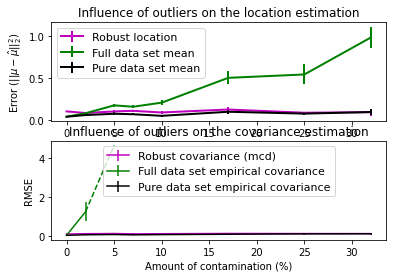

In [17]:
# Display results
font_prop = matplotlib.font_manager.FontProperties(size=11)
plt.subplot(2, 1, 1)
lw = 2
plt.errorbar(range_n_outliers, err_loc_mcd.mean(1),
             yerr=err_loc_mcd.std(1) / np.sqrt(repeat),
             label="Robust location", lw=lw, color='m')

plt.errorbar(range_n_outliers, err_loc_emp_full.mean(1),
             yerr=err_loc_emp_full.std(1) / np.sqrt(repeat),
             label="Full data set mean", lw=lw, color='green')

plt.errorbar(range_n_outliers, err_loc_emp_pure.mean(1),
             yerr=err_loc_emp_pure.std(1) / np.sqrt(repeat),
             label="Pure data set mean", lw=lw, color='black')

plt.title("Influence of outliers on the location estimation")
plt.ylabel(r"Error ($||\mu - \hat{\mu}||_2^2$)")
plt.legend(loc="upper left", prop=font_prop)


plt.subplot(2, 1, 2)
x_size = range_n_outliers.size
plt.errorbar(range_n_outliers, err_cov_mcd.mean(1),
             yerr=err_cov_mcd.std(1),
             label="Robust covariance (mcd)", color='m')

plt.errorbar(range_n_outliers[:(x_size // 5 + 1)],
             err_cov_emp_full.mean(1)[:(x_size // 5 + 1)],
             yerr=err_cov_emp_full.std(1)[:(x_size // 5 + 1)],
             label="Full data set empirical covariance", color='green')

plt.plot(range_n_outliers[(x_size // 5):(x_size // 2 - 1)],
         err_cov_emp_full.mean(1)[(x_size // 5):(x_size // 2 - 1)],
         color='green', ls='--')

plt.errorbar(range_n_outliers, err_cov_emp_pure.mean(1),
             yerr=err_cov_emp_pure.std(1),
             label="Pure data set empirical covariance", color='black')

plt.title("Influence of outliers on the covariance estimation")
plt.xlabel("Amount of contamination (%)")
plt.ylabel("RMSE")
plt.legend(loc="upper center", prop=font_prop)

plt.show()

## Example: CV estimates & Mahalanobis distance - Gaussian data

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

n_samples = 125
n_outliers = 25
n_features = 2

# generate data
gen_cov       = np.eye(n_features)
gen_cov[0, 0] = 2.0
X             = np.dot(np.random.randn(n_samples, 
                                       n_features), 
                       gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), 
             np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, 
                                         n_features), 
                         outliers_cov)

# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(X)

# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)

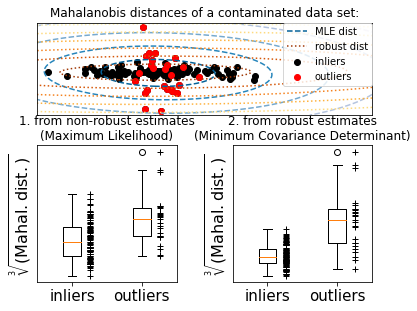

In [19]:
# Display results
fig = plt.figure()
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(3, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], 
                              X[:, 1],
                              color='black', label='inliers')

outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], 
                               X[:, 1][-n_outliers:],
                               color='red', label='outliers')

subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], 
                                 plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], 
                                 plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, 
                                  yy, 
                                  np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, 
                                 yy, 
                                 np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, 
                                 linestyles='dotted')

subfig1.legend([emp_cov_contour.collections[1], 
                robust_contour.collections[1],
                inlier_plot, 
                outlier_plot],
               ['MLE dist', 'robust dist', 'inliers', 'outliers'],
               loc="upper right", borderaxespad=0)
plt.xticks(())
plt.yticks(())


# Plot the scores for each point
subfig2 = plt.subplot(2, 2, 3)

emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)

subfig2.boxplot([emp_mahal[:-n_outliers], 
                 emp_mahal[-n_outliers:]], widths=.25)

subfig2.plot(np.full(n_samples - n_outliers, 1.26),
             emp_mahal[:-n_outliers], 
             '+k', markeredgewidth=1)

subfig2.plot(np.full(n_outliers, 2.26),
             emp_mahal[-n_outliers:], 
             '+k', markeredgewidth=1)

subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
plt.yticks(())

subfig3 = plt.subplot(2, 2, 4)

robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
subfig3.boxplot([robust_mahal[:-n_outliers], 
                 robust_mahal[-n_outliers:]],
                widths=.25)

subfig3.plot(np.full(n_samples - n_outliers, 
                     1.26),
             robust_mahal[:-n_outliers], 
             '+k', markeredgewidth=1)

subfig3.plot(np.full(n_outliers, 
                     2.26),
             robust_mahal[-n_outliers:], 
             '+k', markeredgewidth=1)

subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
plt.yticks(())

plt.show()